In [1]:
import pandas as pd
df = pd.read_csv('hungarian_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:56:31.948000,PIA,81,0 days 00:01:26.746000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:29.625000,...,True,McLaren,0 days 00:55:04.938000,2024-07-21 13:02:58.551,1,1.0,False,NaN,False,False
1,0 days 00:57:55.986000,PIA,81,0 days 00:01:24.038000,2.0,1.0,NaN,NaN,0 days 00:00:29.924000,0 days 00:00:30.425000,...,True,McLaren,0 days 00:56:31.948000,2024-07-21 13:04:25.561,1,1.0,False,NaN,False,True
2,0 days 00:59:20.387000,PIA,81,0 days 00:01:24.401000,3.0,1.0,NaN,NaN,0 days 00:00:30.303000,0 days 00:00:30.297000,...,True,McLaren,0 days 00:57:55.986000,2024-07-21 13:05:49.599,1,1.0,False,NaN,False,True
3,0 days 01:00:44.502000,PIA,81,0 days 00:01:24.115000,4.0,1.0,NaN,NaN,0 days 00:00:30.145000,0 days 00:00:30.338000,...,True,McLaren,0 days 00:59:20.387000,2024-07-21 13:07:14.000,1,1.0,False,NaN,False,True
4,0 days 01:02:08.298000,PIA,81,0 days 00:01:23.796000,5.0,1.0,NaN,NaN,0 days 00:00:30.091000,0 days 00:00:30.157000,...,True,McLaren,0 days 01:00:44.502000,2024-07-21 13:08:38.115,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,0 days 01:37:07.036000,GAS,10,0 days 00:01:41.671000,29.0,2.0,0 days 01:35:45.056000,NaN,0 days 00:00:47.902000,0 days 00:00:30.206000,...,True,Alpine,0 days 01:35:25.365000,2024-07-21 13:43:18.978,1,19.0,False,NaN,False,False
1351,0 days 01:38:30.482000,GAS,10,0 days 00:01:23.446000,30.0,2.0,NaN,NaN,0 days 00:00:29.727000,0 days 00:00:30.081000,...,True,Alpine,0 days 01:37:07.036000,2024-07-21 13:45:00.649,1,17.0,False,NaN,False,True
1352,0 days 01:39:53.822000,GAS,10,0 days 00:01:23.340000,31.0,2.0,NaN,NaN,0 days 00:00:29.754000,0 days 00:00:30.046000,...,True,Alpine,0 days 01:38:30.482000,2024-07-21 13:46:24.095,1,16.0,False,NaN,False,True
1353,0 days 01:41:17.306000,GAS,10,0 days 00:01:23.484000,32.0,2.0,NaN,NaN,0 days 00:00:29.652000,0 days 00:00:30.176000,...,True,Alpine,0 days 01:39:53.822000,2024-07-21 13:47:47.435,1,15.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 70  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2               7.0          23.000000   
1    ALO              2               8.0          23.333333   
2    BOT              2              17.0          23.000000   
3    GAS              1              29.0          16.500000   
4    HAM              2              17.0          23.333333   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.086957          0.000000         0.913043  
1          0.100000          0.428571         0.471429  
2          0.000000          0.231884         0.768116  
3          0.000000          0.151515         0.848485  
4          0.000000          0.228571         0.771429  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,6.0,0 days 01:03:49.888000,NaN,SOFT,6.0,1.0
1,ALB,7.0,NaN,0 days 01:04:11.969000,HARD,1.0,2.0
2,ALB,29.0,0 days 01:36:53.545000,NaN,HARD,23.0,2.0
3,ALB,30.0,NaN,0 days 01:37:17.126000,HARD,1.0,3.0
4,ALO,7.0,0 days 01:05:12.367000,NaN,SOFT,9.0,1.0
...,...,...,...,...,...,...,...
77,VER,50.0,NaN,0 days 02:04:30.977000,MEDIUM,1.0,3.0
78,ZHO,7.0,0 days 01:05:22.041000,NaN,MEDIUM,8.0,1.0
79,ZHO,8.0,NaN,0 days 01:05:43.972000,HARD,1.0,2.0
80,ZHO,36.0,0 days 01:47:10.178000,NaN,HARD,29.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,7.0,23.000000,0.086957,0.000000,0.913043
1,ALO,2,8.0,23.333333,0.100000,0.428571,0.471429
2,BOT,2,17.0,23.000000,0.000000,0.231884,0.768116
3,GAS,1,29.0,16.500000,0.000000,0.151515,0.848485
4,HAM,2,17.0,23.333333,0.000000,0.228571,0.771429
5,HUL,2,3.0,23.000000,0.000000,0.028986,0.971014
6,LEC,2,24.0,23.333333,0.000000,0.757143,0.242857
7,MAG,2,7.0,23.000000,0.086957,0.000000,0.913043
8,NOR,2,18.0,23.333333,0.000000,0.600000,0.400000
9,OCO,3,7.0,17.250000,0.072464,0.086957,0.840580


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1254


In [9]:
df['Driver'].value_counts()


,count
Driver,
TSU,67
PIA,65
HAM,65
NOR,65
LEC,65
VER,65
PER,65
SAI,65
RUS,65


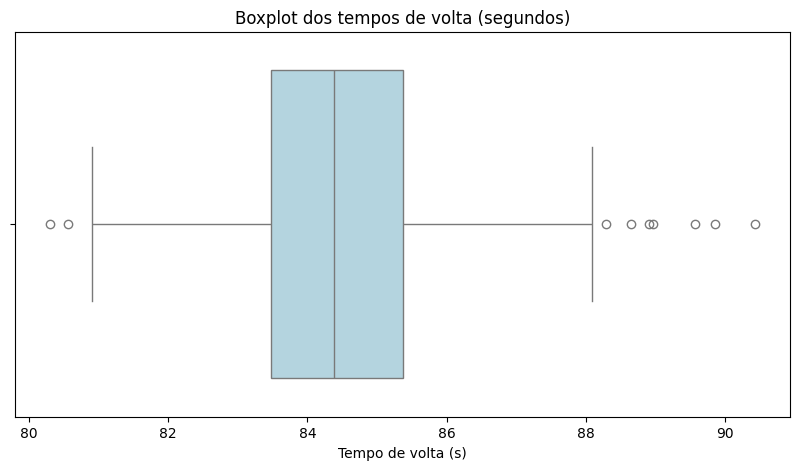

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


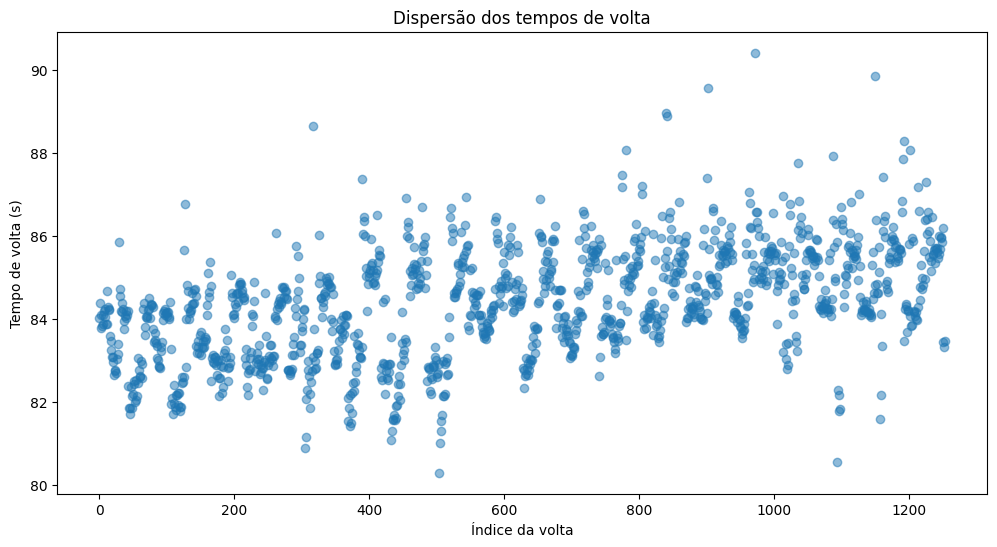

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


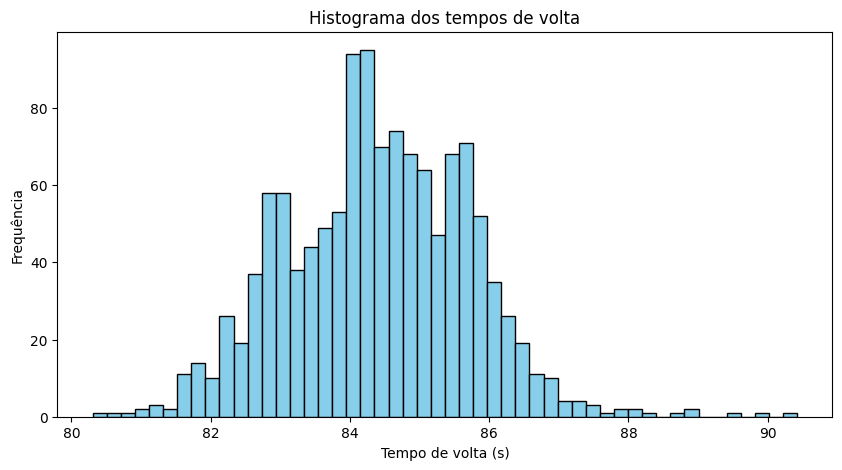

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


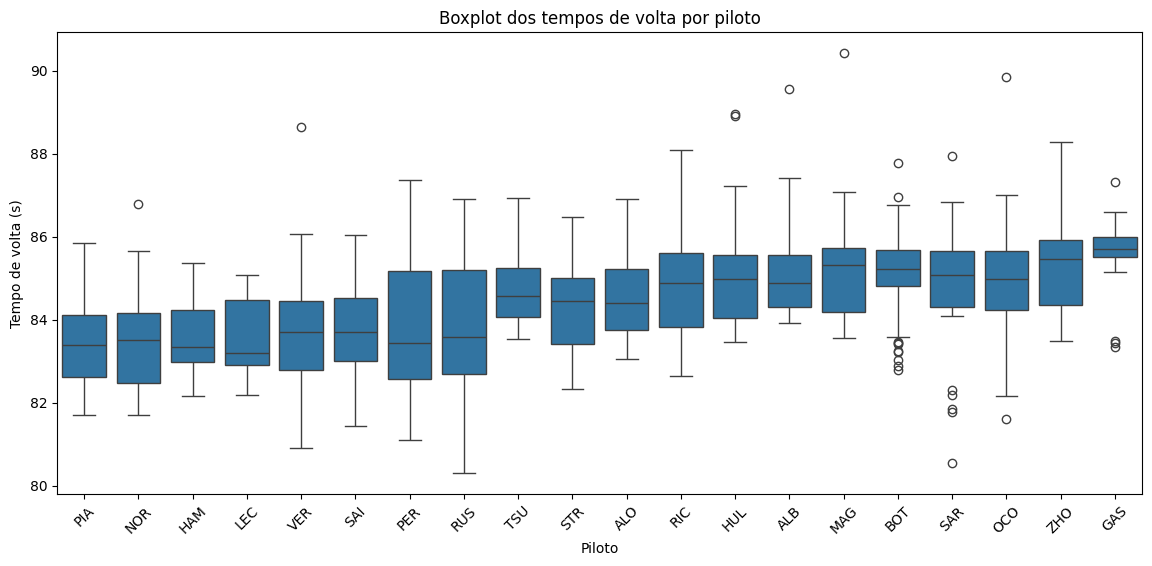

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
RUS   0 days 00:01:20.305000
SAR   0 days 00:01:20.561000
VER   0 days 00:01:20.908000
PER   0 days 00:01:21.096000
SAI   0 days 00:01:21.441000
OCO   0 days 00:01:21.610000
NOR   0 days 00:01:21.712000
PIA   0 days 00:01:21.716000
HAM   0 days 00:01:22.153000
LEC   0 days 00:01:22.182000
STR   0 days 00:01:22.338000
RIC   0 days 00:01:22.640000
BOT   0 days 00:01:22.792000
ALO   0 days 00:01:23.063000
GAS   0 days 00:01:23.340000
HUL   0 days 00:01:23.461000
ZHO   0 days 00:01:23.487000
TSU   0 days 00:01:23.533000
MAG   0 days 00:01:23.553000
ALB   0 days 00:01:23.930000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Hungria'
race_date = '2024-07-21'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,64,85.055594,0.978974,83.930,89.563,84.8905,5.633,2024,Hungria,2024-07-21
1,ALO,65,84.537954,0.947438,83.063,86.908,84.4020,3.845,2024,Hungria,2024-07-21
2,BOT,64,85.157328,1.039632,82.792,87.777,85.2155,4.985,2024,Hungria,2024-07-21
3,GAS,29,85.615966,0.873934,83.340,87.321,85.7030,3.981,2024,Hungria,2024-07-21
4,HAM,65,83.543308,0.777914,82.153,85.372,83.3340,3.219,2024,Hungria,2024-07-21
5,HUL,64,84.976703,1.156229,83.461,88.970,84.9740,5.509,2024,Hungria,2024-07-21
6,LEC,65,83.591092,0.838180,82.182,85.076,83.2070,2.894,2024,Hungria,2024-07-21
7,MAG,64,85.178891,1.121568,83.553,90.424,85.3205,6.871,2024,Hungria,2024-07-21
8,NOR,65,83.402615,1.028976,81.712,86.787,83.5140,5.075,2024,Hungria,2024-07-21
9,OCO,62,85.043081,1.167496,81.610,89.856,84.9880,8.246,2024,Hungria,2024-07-21


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,64,85.055594,0.978974,83.930,89.563,84.8905,5.633,2024,Hungria,2024-07-21,69.0,True
1,ALO,65,84.537954,0.947438,83.063,86.908,84.4020,3.845,2024,Hungria,2024-07-21,70.0,True
2,BOT,64,85.157328,1.039632,82.792,87.777,85.2155,4.985,2024,Hungria,2024-07-21,69.0,True
3,GAS,29,85.615966,0.873934,83.340,87.321,85.7030,3.981,2024,Hungria,2024-07-21,33.0,False
4,HAM,65,83.543308,0.777914,82.153,85.372,83.3340,3.219,2024,Hungria,2024-07-21,70.0,True
5,HUL,64,84.976703,1.156229,83.461,88.970,84.9740,5.509,2024,Hungria,2024-07-21,69.0,True
6,LEC,65,83.591092,0.838180,82.182,85.076,83.2070,2.894,2024,Hungria,2024-07-21,70.0,True
7,MAG,64,85.178891,1.121568,83.553,90.424,85.3205,6.871,2024,Hungria,2024-07-21,69.0,True
8,NOR,65,83.402615,1.028976,81.712,86.787,83.5140,5.075,2024,Hungria,2024-07-21,70.0,True
9,OCO,62,85.043081,1.167496,81.610,89.856,84.9880,8.246,2024,Hungria,2024-07-21,69.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,7.0,23.000000,0.086957,0.000000,0.913043
1,ALO,2,8.0,23.333333,0.100000,0.428571,0.471429
2,BOT,2,17.0,23.000000,0.000000,0.231884,0.768116
3,GAS,1,29.0,16.500000,0.000000,0.151515,0.848485
4,HAM,2,17.0,23.333333,0.000000,0.228571,0.771429
5,HUL,2,3.0,23.000000,0.000000,0.028986,0.971014
6,LEC,2,24.0,23.333333,0.000000,0.757143,0.242857
7,MAG,2,7.0,23.000000,0.086957,0.000000,0.913043
8,NOR,2,18.0,23.333333,0.000000,0.600000,0.400000
9,OCO,3,7.0,17.250000,0.072464,0.086957,0.840580


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,64,85.055594,0.978974,83.930,89.563,84.8905,5.633,2024,Hungria,2024-07-21,69.0,True,2,7.0,23.000000,0.086957,0.000000,0.913043
1,ALO,65,84.537954,0.947438,83.063,86.908,84.4020,3.845,2024,Hungria,2024-07-21,70.0,True,2,8.0,23.333333,0.100000,0.428571,0.471429
2,BOT,64,85.157328,1.039632,82.792,87.777,85.2155,4.985,2024,Hungria,2024-07-21,69.0,True,2,17.0,23.000000,0.000000,0.231884,0.768116
3,GAS,29,85.615966,0.873934,83.340,87.321,85.7030,3.981,2024,Hungria,2024-07-21,33.0,False,1,29.0,16.500000,0.000000,0.151515,0.848485
4,HAM,65,83.543308,0.777914,82.153,85.372,83.3340,3.219,2024,Hungria,2024-07-21,70.0,True,2,17.0,23.333333,0.000000,0.228571,0.771429
5,HUL,64,84.976703,1.156229,83.461,88.970,84.9740,5.509,2024,Hungria,2024-07-21,69.0,True,2,3.0,23.000000,0.000000,0.028986,0.971014
6,LEC,65,83.591092,0.838180,82.182,85.076,83.2070,2.894,2024,Hungria,2024-07-21,70.0,True,2,24.0,23.333333,0.000000,0.757143,0.242857
7,MAG,64,85.178891,1.121568,83.553,90.424,85.3205,6.871,2024,Hungria,2024-07-21,69.0,True,2,7.0,23.000000,0.086957,0.000000,0.913043
8,NOR,65,83.402615,1.028976,81.712,86.787,83.5140,5.075,2024,Hungria,2024-07-21,70.0,True,2,18.0,23.333333,0.000000,0.600000,0.400000
9,OCO,62,85.043081,1.167496,81.610,89.856,84.9880,8.246,2024,Hungria,2024-07-21,69.0,True,3,7.0,17.250000,0.072464,0.086957,0.840580


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoHungria.csv', index=False)
